# House price prediction using linear regression (minimal)

보스턴 주택 데이터 세트 사용: https://www.kaggle.com/c/boston-housing/

* CRIM	    자치시(town) 별 1인당 범죄율
* ZN	    25,000 평방피트를 초과하는 거주지역의 비율
* INDUS	    비소매상업지역이 점유하고 있는 토지의 비율
* CHAS	    찰스강에 대한 더미변수(강의 경계에 위치한 경우는 1, 아니면 0)
* NOX	    10ppm 당 농축 일산화질소
* RM	    주택 1가구당 평균 방의 개수
* AGE	    1940년 이전에 건축된 소유주택의 비율
* DIS	    5개의 보스턴 직업센터까지의 접근성 지수
* RAD	    방사형 도로까지의 접근성 지수
* TAX	    10,000 달러 당 재산세율
* PTRATIO	자치시(town)별 학생/교사 비율
* B	        1000(Bk-0.63)^2, 여기서 Bk는 자치시별 흑인의 비율을 말함.
* LSTAT	    모집단의 하위계층의 비율(%)
* MEDV	    본인 소유의 주택가격(중앙값) (단위: $1,000) -> Target

In [1]:
import torch
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

In [2]:
# Hyperparameters
batch_size=64
learning_rate=5e-7

# Other constants
DATASET_URL = "https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv"
DATA_FILENAME = "BostonHousing.csv"
TARGET_COLUMN = 'medv'
input_size=13
output_size=1

## Dataset & Data loaders

In [3]:
download_url(DATASET_URL, '.')
dataframe = pd.read_csv(DATA_FILENAME)
dataframe.head()

0it [00:00, ?it/s]

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [4]:
# Convert from Pandas dataframe to numpy arrays
inputs = dataframe.drop('medv', axis=1).values
targets = dataframe[['medv']].values
inputs.shape, targets.shape

((506, 13), (506, 1))

In [5]:
dataset = TensorDataset(torch.tensor(inputs, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32))
train_ds, val_ds = random_split(dataset, [406, 100])

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

## Model

In [6]:
class HousingModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)
        
    def forward(self, xb):
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        inputs, targets = batch
        out = self(inputs)
        loss = F.mse_loss(out, targets)
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        out = self(inputs)
        loss = F.mse_loss(out, targets)
        return {'val_loss': loss.detach()}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}".format(epoch, result['val_loss']))

In [7]:
model = HousingModel()

## Training

In [8]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [9]:
result = evaluate(model, val_loader)
result

{'val_loss': 15237.353515625}

In [10]:
history = fit(10, learning_rate, model, train_loader, val_loader)

Epoch [0], val_loss: 537.9697
Epoch [1], val_loss: 410.7170
Epoch [2], val_loss: 334.0815
Epoch [3], val_loss: 255.6349
Epoch [4], val_loss: 215.6040
Epoch [5], val_loss: 179.8975
Epoch [6], val_loss: 155.2205
Epoch [7], val_loss: 140.1239
Epoch [8], val_loss: 127.1720
Epoch [9], val_loss: 117.8206


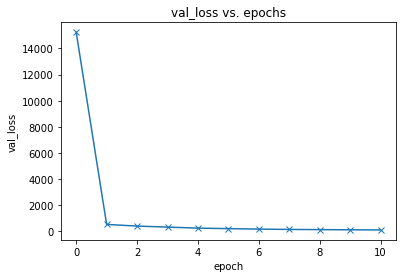

In [11]:
losses = [r['val_loss'] for r in [result] + history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('val_loss')
plt.title('val_loss vs. epochs');

## Prediction

In [12]:
def predict_single(x, model):
    xb = x.unsqueeze(0)
    return model(xb).item()

In [13]:
x, target = val_ds[10]
pred = predict_single(x, model)
print("Input: ", x)
print("Target: ", target.item())
print("Prediction:", pred)

Input:  tensor([ 15.1772,   0.0000,  18.1000,   0.0000,   0.7400,   6.1520, 100.0000,
          1.9142,  24.0000, 666.0000,  20.2000,   9.3200,  26.4500])
Target:  8.699999809265137
Prediction: 20.765649795532227


## Save and upload

In [ ]:
torch.save(model.state_dict(), 'housing-linear.pth')